In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import alexnet
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader, random_split
import torch.optim as optim
from tqdm import tqdm 
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from torchvision import transforms
import pandas as pd

In [ ]:
# ----- Vérification de l'utilisation du GPU -----
!nvidia-smi 

# ----- Optimisation Pytorch -----
torch.backends.cudnn.benchmark = True                                   # accélère les convolutions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Utilisation de :", device)

Sat Nov 15 15:43:43 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.30                 Driver Version: 546.30       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   57C    P8              14W /  95W |   3868MiB /  6144MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Implementation de AlexNet

### Creation de l'architecture

- Feature Extractor : 

La première couche de convolution prend une image à 3 canaux et passe un kernel de taille 11x11 avec un pas de 4 réduit. Les fonction d'activation sont des ReLu (conserve les y positives et renvoi 0 pour les y négatifs). Ensuite, un maxpooling est appliqué pour réduire la dimension des images et concerver les informations importantes

- Classifier : 

Ensemble de percptron multi-couches avec des fonction d'activation ReLu Les features (les x) sont projetées dans un espace de grande dimension ici de taille 4096. La dernière couches est la sortie du reseau

- Forward : 

Calcul du lien entre les entrées et les sorties (f(x)) ou on défini le passage des entrées dans le Feature extractor, les features sont transformées en vecteur (fletten) puis les vecteurs de features sont passées dans les PMC.

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):   # nombre de classes de AlexNet de bases
        super(AlexNet, self).__init__()

        # ----- Feature Extractor = couches de convolution et pooling -----
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),          # Conv1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                          # MaxPool1
            nn.Conv2d(64, 192, kernel_size=5, padding=2),                   # Conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                          # MaxPool2
            nn.Conv2d(192, 384, kernel_size=3, padding=1),                  # Conv3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),                  # Conv4
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),                  # Conv5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                          # MaxPool3
        )

        # ----- Classifier = couches de PMC -----
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),         # couche de sortie
        )

    # ----- Calcul des f(x) -----
    def forward(self, x):
        x = self.features(x)      # calcul a traver les couches de convolution
        x = torch.flatten(x, 1)   # les sorties de la convolution sont transformées en vecteurs pour être utilisable par les PMC
        x = self.classifier(x)    # calcul a traver les couches de PMC
        return x

NameError: name 'nn' is not defined

### Traitement des données

- Fonction dé-zippeur

In [ ]:
class ZipImageFolder(Dataset):
    """
    Version ZIP de ImageFolder : le ZIP contient des sous-dossiers par classe.
    """
    def __init__(self, zip_path, transform=None):
        self.zip_path = zip_path
        self.transform = transform
        self.z = zipfile.ZipFile(zip_path)

        # ----- Tous les fichiers image -----
        self.img_files = [f for f in self.z.namelist()
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # ----- Extraction classes : nom du dossier parent -----
        self.classes = sorted(list({f.split('/')[1] for f in self.img_files}))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # ----- Construction d’une liste [(path, label)] -----
        self.samples = []
        for f in self.img_files:
            parts = f.split("/")
            if len(parts) >= 3:
                cls = parts[1]
                label = self.class_to_idx[cls]
                self.samples.append((f, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        with self.z.open(img_path) as f:
            img = Image.open(f).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

- Chargement des données

- Transformation des données : 

Ici  les images sont converties en tenseurs, la taille des images est modifiée et enfin normalisées. En effet, AlexNet doit traiter des images en 227x227 pixels. Le normalisation permet une convergence plus rapide.

- Création d'un dataloader

In [ ]:
#-#-#-#-# Transformation des données : exemple complet pour 100 images par espèces #-#-#-#-#

# ----- Set-up de la transformation -----
zip_root = "DATA/100_img.zip"

temp_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])

temp_dataset = ZipImageFolder(zip_root, transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)

# ----- Calcul de moyenne / écart-type -----
mean = 0.0
std = 0.0
total_images = 0

for images, _ in temp_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images

print("Mean :", mean)
print("Std  :", std)

# ----- Transformation finale -----
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

# ----- Dataset complet depuis le ZIP -----
dataset = ZipImageFolder(zip_root, transform=transform)

# ----- Train/test split -----
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# ----- DataLoaders -----
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)

print("Classes :", dataset.classes)
print("Total images :", len(dataset))


### Fine-Tuning et transfert d'apprentissage

En remplaçant la dernière couche entièrement connectée (model.classifier[6]), on indique à AlexNet d'ajuster ses prédictions à votre ensemble de données personnalisé. Les couches antérieures restent intactes, conservant les caractéristiques apprises, tandis que la nouvelle couche apprend à classer vos catégories spécifiques.




====== TRAINING POUR : DATA/5_img.zip ======

Epoch 1/50 - Loss: 2.9316 - Train Acc: 3.12% - Test Acc: 0.00%
Epoch 2/50 - Loss: 2.8491 - Train Acc: 6.25% - Test Acc: 0.00%
Epoch 3/50 - Loss: 2.7211 - Train Acc: 9.38% - Test Acc: 0.00%
Epoch 4/50 - Loss: 2.5127 - Train Acc: 18.75% - Test Acc: 0.00%
Epoch 5/50 - Loss: 2.3409 - Train Acc: 25.00% - Test Acc: 6.25%
Epoch 6/50 - Loss: 2.1261 - Train Acc: 37.50% - Test Acc: 6.25%
Epoch 7/50 - Loss: 1.9672 - Train Acc: 42.19% - Test Acc: 18.75%
Epoch 8/50 - Loss: 1.7590 - Train Acc: 50.00% - Test Acc: 18.75%
Epoch 9/50 - Loss: 1.5766 - Train Acc: 64.06% - Test Acc: 25.00%
Epoch 10/50 - Loss: 1.3664 - Train Acc: 73.44% - Test Acc: 31.25%
Epoch 11/50 - Loss: 1.2341 - Train Acc: 75.00% - Test Acc: 31.25%
Epoch 12/50 - Loss: 1.0517 - Train Acc: 82.81% - Test Acc: 37.50%
Epoch 13/50 - Loss: 1.0034 - Train Acc: 85.94% - Test Acc: 37.50%
Epoch 14/50 - Loss: 0.7859 - Train Acc: 87.50% - Test Acc: 37.50%
Epoch 15/50 - Loss: 0.7531 - Train Acc: 87.50% 

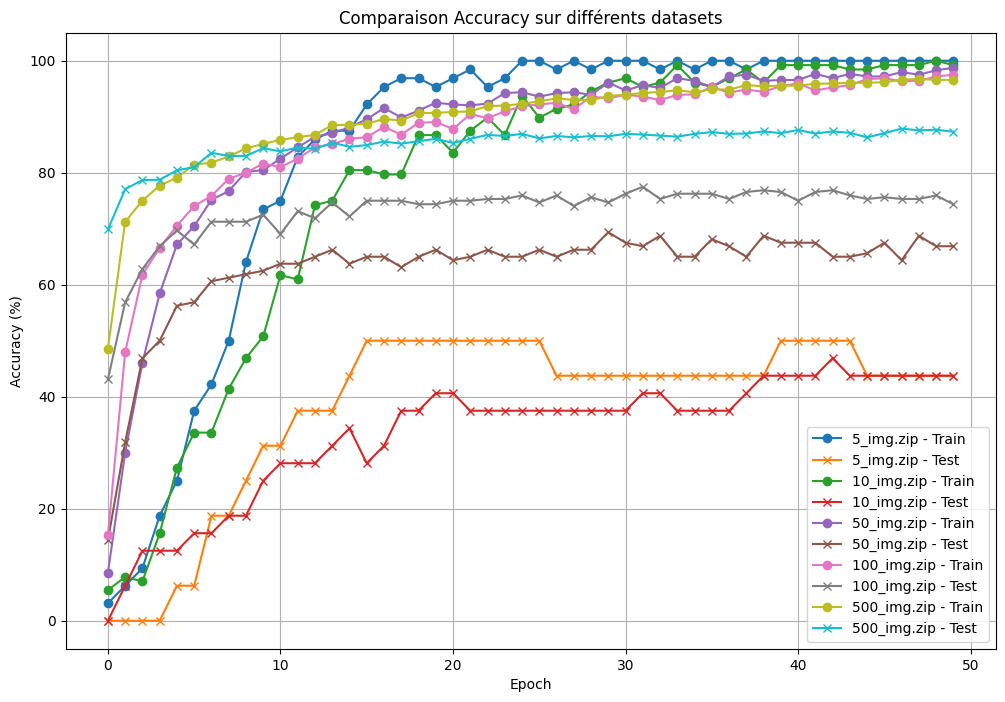

In [ ]:
# ----- Liste des datasets ZIP qu'on va utiliser -----
zip_list = [
    "DATA/5_img.zip",
    "DATA/10_img.zip",
    "DATA/50_img.zip",
    "DATA/100_img.zip",
    "DATA/500_img.zip",
]

# ----- Pour stocker toutes les courbes -----
all_train_accuracies = {}
all_test_accuracies = {}


#-#-#-#-# Liste des fonctions qu'on utilisera dans le training #-#-#-#-#

# ----- Fonction : calcul de la moyenne  -----
def compute_mean_std(zip_path):
    temp_transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor()
    ])
    temp_dataset = ZipImageFolder(zip_path, transform=temp_transform)
    temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)

    mean = 0.0
    std = 0.0
    total = 0

    for images, _ in temp_loader:
        b = images.size(0)
        images = images.view(b, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total += b

    mean /= total
    std /= total
    return mean, std

# ----- Évaluation sur le test_loader -----
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# ----- Training AlexNet -----
def train_model(zip_path, num_epochs=50):
    print(f"\n====== TRAINING POUR : {zip_path} ======\n")

    mean, std = compute_mean_std(zip_path)
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
    ])

    dataset = ZipImageFolder(zip_path, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    model = alexnet(pretrained=True).to('cuda')
    model.classifier[6] = nn.Linear(4096, len(dataset.classes)).to('cuda')

    for p in model.features.parameters():
        p.requires_grad = False

    criterion = nn.CrossEntropyLoss().to('cuda')
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        test_acc = evaluate(model, test_loader)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f} "
              f"- Train Acc: {train_acc:.2f}% - Test Acc: {test_acc:.2f}%")

    return train_accuracies, test_accuracies

#-#-#-#-# Lancement pour tous les ZIP #-#-#-#-#-#

for zip_path in zip_list:
    train_acc, test_acc = train_model(zip_path)
    label = zip_path.split("/")[-1]
    all_train_accuracies[label] = train_acc
    all_test_accuracies[label] = test_acc

### Plot final

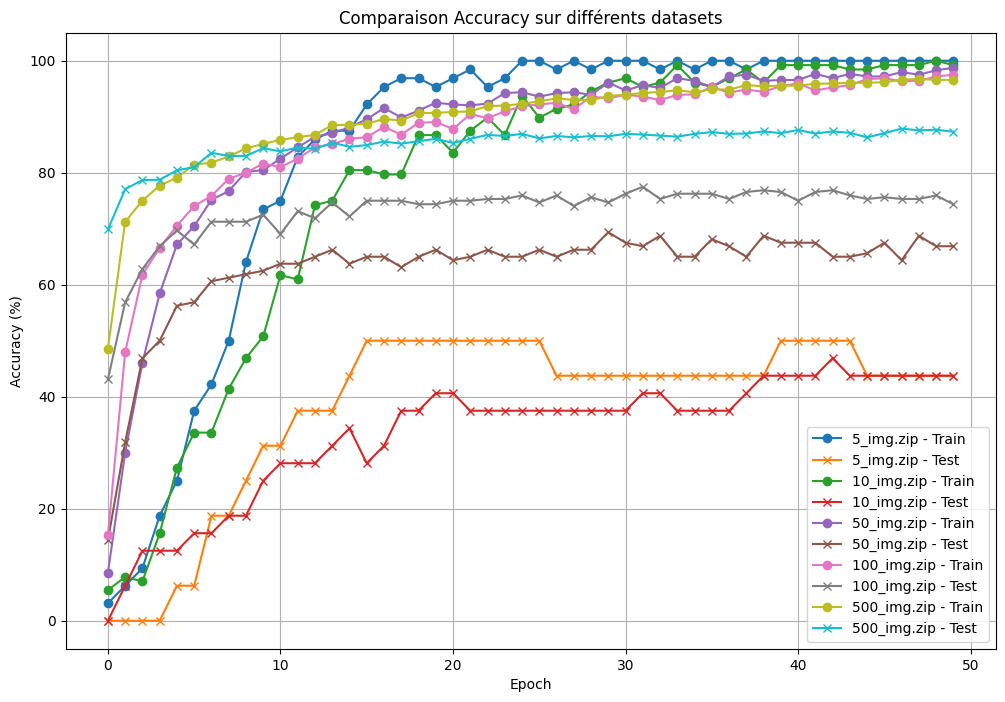

<Figure size 640x480 with 0 Axes>

In [ ]:
# ----- Plot final -----
plt.figure(figsize=(12,8))

for name in zip_list:
    label = name.split("/")[-1]
    plt.plot(all_train_accuracies[label], marker='o', label=f"{label} - Train")
    plt.plot(all_test_accuracies[label], marker='x', label=f"{label} - Test")

plt.title("Comparaison Accuracy sur différents datasets")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.savefig("comparaison_accuracy.svg", format="svg")
plt.show()


Export des données

In [ ]:
#-#-#-#-# Préparer le dictionnaire pour le CSV #-#-#-#-#

# Chaque colonne = train/test accuracy pour un dataset 
# Chaque ligne = epoch

# ----- On va créer un DataFrame avec multiIndex pour les colonnes : (dataset, type) -----
columns = []
data = {}

num_epochs = len(next(iter(all_train_accuracies.values())))    # nombre d'epochs

for dataset in all_train_accuracies.keys():

    # ----- Train ------
    columns.append((dataset, 'train'))
    data[(dataset, 'train')] = all_train_accuracies[dataset]

    # ----- Test -----
    columns.append((dataset, 'test'))
    data[(dataset, 'test')] = all_test_accuracies[dataset]

# ----- Créer le DataFrame -----
df = pd.DataFrame(data)
df.index.name = 'epoch'

# ----- Sauvegarder dans un CSV -----
df.to_csv("accuracy_results.csv")
print("Données écrites dans accuracy_results.csv")


NameError: name 'all_train_accuracies' is not defined